<a href="https://colab.research.google.com/github/adesewa12/Data-Analysis/blob/main/dsc_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DSC ANALYSIS NOTEBOOK
                 

## **Notebook Overview: Adaptive DSC Experiment Analysis with TADataKit**
### **Purpose**

This notebook provides an end-to-end, reproducible workflow for **loading, exploring, processing, and analyzing** Differential Scanning Calorimetry (DSC) experiment data exported from TA Instruments’ TRIOS software. It is tailored for workflows where analysts need to quickly extract scientifically relevant features from thermal analysis data and suggest analysis limits adaptively, based on characteristic curve features such as peaks and inflection points.

### **Key Objectives**


1.   **Load and Inspect TRIOS JSON Data**
    * Uses TADataKit to parse TRIOS-exported .json files into pandas DataFrames.
    * Displays dataset shape, metadata, and procedure steps.
    * Lists all available measurement channels in a given experiment.

2.   **Select Relevant DSC Channels**
    * Filters down to core DSC measurement variables:

        * Power Delivered / W

        *  Modulated Temperature / °C

        * Modulated Heat Flow / mW

        * Temperature / °C

        * Heat Flow / mW

        *  Total Heat Flow / mW

        * Heat Flow Phase / rad

        * Reversing Heat Flow / mW

        * Non-Reversing Heat Flow / mW

        * Reversing Heat Capacity / J/°C

3.   **Feature Extraction**
     * Smooths heat flow data using a Savitzky–Golay filter.

     * Computes first and second derivatives.

     * Detects:

        * **Peaks** (endothermic/exothermic events).

        * **Inflection Points** (zero-crossings of second derivative).

        * **Baseline/flat regions** (low-derivative segments).

4.   **Rule-Based Limit Suggestion**
  * Identifies the last inflection point before the first major peak.

  * Suggests start/end analysis limits using configurable offsets (default: start = inflection − 5 °C, end = peak + 10 °C).

  * Designed for quick adaptation to repeated analyses of similar materials.

5.   **Visualization**
  * Plots smoothed heat flow vs. temperature.

  * Annotates:

      * Detected peaks.

      * Inflection points.

      * Suggested analysis limits.

  * Provides clear, publication-ready plots for review or inclusion in reports

6.   **Time Since Experiment**
  * Demonstrates extending TADataKit’s Experiment object with custom methods (e.g., time elapsed since the experiment’s start).





### **Intended Use Cases**
* **High-throughput labs** wanting to speed up DSC analysis without losing
interpretability.

* **Analytical scientists** needing a balance between automation and control.

* **Method development** for adaptive, feature-driven limit placement in thermal analysis SOPs.


### **Outputs**
- Interactive display of:
  - Raw and selected measurement channels.
  - Feature detection results (lists of peaks and inflections).
  - Suggested start/end limits for the primary transition.
-  annotated plots.

### **Requirements**
- Python 3.8+
- Installed packages:
  ```bash
  pip install tadatakit pandas numpy scipy matplotlib pytz


In [ ]:
# DSC_Analysis_Notebook.ipynb

# --- 1. Install dependencies ---
!pip install tadatakit pandas numpy scipy matplotlib pytz

In [ ]:
# --- 2. Imports ---
import datetime
import pytz
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
from tadatakit.classes import Experiment

In [ ]:
# --- 3. Load JSON into Experiment ---
json_path = "/content/4535 rb19-br-00301 1699437.json"  # <-- change path as needed
ovenCheck= "/content/4535 - Oven Check - PE.json"
experiment = Experiment.from_json(json_path)
baseline =  Experiment.from_json(ovenCheck)
df = experiment.get_dataframe()
baseline_df = baseline.get_dataframe()
#automate this
frames = [df, baseline_df]
for frame in frames:
  if frame is None or frame.empty:
    print("Error: Could not load data into DataFrame or the DataFrame is empty.")
  else:
    print(f"DataFrame shape: {frame.shape}")
    print("First 5 rows:")
    display(frame.head())

DataFrame shape: (2385, 20)
First 5 rows:


,Cell Purge / mL/min,Heater Temp / °C,Reference Junction Temperature / °C,Delta T / µV,Time / min,Delta Tzero / µV,Results Step Id,Tzero Temperature / °C,Procedure Step Id,Flange Temperature / °C,Power Delivered / W,Modulated Temperature / °C,Modulated Heat Flow / mW,Temperature / °C,Heat Flow / mW,Total Heat Flow / mW,Heat Flow Phase / rad,Reversing Heat Flow / mW,Non-Reversing Heat Flow / mW,Reversing Heat Capacity / J/°C
0,50.004800,21.956867,46.166569,-2.447177,0.007500,39.450581,551e1402-ce57-4305-bfa0-14de32be392c,21.123461,0000a37e-0000-0000-0000-000000000000,-46.844852,30.212490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50.005355,22.054380,46.166595,-2.355782,0.024167,37.091104,551e1402-ce57-4305-bfa0-14de32be392c,21.227972,0000a37e-0000-0000-0000-000000000000,-46.845158,30.338621,20.617191,-0.681376,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,49.999575,22.152029,46.166611,-2.255397,0.040833,35.284909,551e1402-ce57-4305-bfa0-14de32be392c,21.319551,0000a37e-0000-0000-0000-000000000000,-46.845390,26.435888,20.737385,-0.652203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50.005041,22.249733,46.166607,-2.175302,0.057500,34.002263,551e1402-ce57-4305-bfa0-14de32be392c,21.412237,0000a37e-0000-0000-0000-000000000000,-46.846428,23.600006,20.851311,-0.621385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50.002097,22.347015,46.166626,-2.105070,0.074167,32.623531,551e1402-ce57-4305-bfa0-14de32be392c,21.498446,0000a37e-0000-0000-0000-000000000000,-46.847015,21.035574,20.960331,-0.599660,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DataFrame shape: (2383, 20)
First 5 rows:


,Cell Purge / mL/min,Heater Temp / °C,Reference Junction Temperature / °C,Delta T / µV,Time / min,Delta Tzero / µV,Results Step Id,Tzero Temperature / °C,Procedure Step Id,Flange Temperature / °C,Power Delivered / W,Modulated Temperature / °C,Modulated Heat Flow / mW,Temperature / °C,Heat Flow / mW,Total Heat Flow / mW,Heat Flow Phase / rad,Reversing Heat Flow / mW,Non-Reversing Heat Flow / mW,Reversing Heat Capacity / J/°C
0,50.003340,22.234159,46.174026,-2.884618,0.007500,19.431638,c2c723e4-0c9d-4384-a909-908d656eec3b,21.282225,0001b77d-0000-0000-0000-000000000000,-46.351658,24.143579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49.997703,22.173910,46.174023,-3.282867,0.024167,13.008805,c2c723e4-0c9d-4384-a909-908d656eec3b,21.184969,0001b77d-0000-0000-0000-000000000000,-46.352718,25.992140,20.966763,-0.922636,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,49.998779,22.131670,46.174038,-3.539836,0.040833,8.476872,c2c723e4-0c9d-4384-a909-908d656eec3b,21.116938,0001b77d-0000-0000-0000-000000000000,-46.354492,23.406038,20.977036,-0.994972,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,49.996320,22.106810,46.174065,-3.500621,0.057500,5.934372,c2c723e4-0c9d-4384-a909-908d656eec3b,21.079077,0001b77d-0000-0000-0000-000000000000,-46.356232,19.939026,20.981026,-0.986168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49.997941,22.103279,46.174099,-3.180937,0.074167,4.355853,c2c723e4-0c9d-4384-a909-908d656eec3b,21.055292,0001b77d-0000-0000-0000-000000000000,-46.358028,16.005371,20.982307,-0.914723,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# data cleaning
#remove Nan and null values
for frame in frames:
  if frame is not None:
    frame.dropna(inplace=True)
    frame.drop_duplicates(inplace=True)
  print(frame.duplicated().sum())


0
0


In [ ]:
# --- 4. Show column names ---
print("\nColumn names:")
for col in df.columns:
    print(col)


Column names:
Cell Purge / mL/min
Heater Temp / °C
Reference Junction Temperature / °C
Delta T / µV
Time / min
Delta Tzero / µV
Results Step Id
Tzero Temperature / °C
Procedure Step Id
Flange Temperature / °C
Power Delivered / W
Modulated Temperature / °C
Modulated Heat Flow / mW
Temperature / °C
Heat Flow / mW
Total Heat Flow / mW
Heat Flow Phase / rad
Reversing Heat Flow / mW
Non-Reversing Heat Flow / mW
Reversing Heat Capacity / J/°C


In [ ]:

# --- 5. Split by step ---
steps, dfs_by_step = experiment.get_dataframes_by_step()
for step, df_step in zip(steps, dfs_by_step):
    print("\nStep:", step)
    display(df_step.head())

for frame in frames:
  if frame is not None:
    steps, dfs_by_step = experiment.get_dataframes_by_step()


Step: Sample Interval  1.0 s/pt


""



Step: Data Off 


""



Step: Event1 On 


""



Step: Equilibrate 20.00 °C


""



Step: Select Gas: Gas 1 


""



Step: Mass Flow  50.00 mL/min


""



Step: Modulate Temperature 1.000 °C for 40.0 s


""



Step: Isothermal 5.0 min


""



Step: Data On 


""



Step: Ramp 5.00 °C/min to 220.00 °C


,Cell Purge / mL/min,Heater Temp / °C,Reference Junction Temperature / °C,Delta T / µV,Time / min,Delta Tzero / µV,Results Step Id,Tzero Temperature / °C,Procedure Step Id,Flange Temperature / °C,Power Delivered / W,Modulated Temperature / °C,Modulated Heat Flow / mW,Temperature / °C,Heat Flow / mW,Total Heat Flow / mW,Heat Flow Phase / rad,Reversing Heat Flow / mW,Non-Reversing Heat Flow / mW,Reversing Heat Capacity / J/°C
0,50.004800,21.956867,46.166569,-2.447177,0.007500,39.450581,551e1402-ce57-4305-bfa0-14de32be392c,21.123461,0000a37e-0000-0000-0000-000000000000,-46.844852,30.212490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50.005355,22.054380,46.166595,-2.355782,0.024167,37.091104,551e1402-ce57-4305-bfa0-14de32be392c,21.227972,0000a37e-0000-0000-0000-000000000000,-46.845158,30.338621,20.617191,-0.681376,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,49.999575,22.152029,46.166611,-2.255397,0.040833,35.284909,551e1402-ce57-4305-bfa0-14de32be392c,21.319551,0000a37e-0000-0000-0000-000000000000,-46.845390,26.435888,20.737385,-0.652203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50.005041,22.249733,46.166607,-2.175302,0.057500,34.002263,551e1402-ce57-4305-bfa0-14de32be392c,21.412237,0000a37e-0000-0000-0000-000000000000,-46.846428,23.600006,20.851311,-0.621385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50.002097,22.347015,46.166626,-2.105070,0.074167,32.623531,551e1402-ce57-4305-bfa0-14de32be392c,21.498446,0000a37e-0000-0000-0000-000000000000,-46.847015,21.035574,20.960331,-0.599660,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Step: Data Off 


""



Step: Equilibrate 20.00 °C


""



Step: Event1 Off 


""


In [ ]:
# --- 6. Add method: time since experiment start --- (adjusted)
def time_since_experiment(self):
    now_aware = datetime.datetime.now(pytz.utc)
    return now_aware - self.start_time

setattr(Experiment, "time_since_experiment", time_since_experiment)
print("\nTime since experiment start:", experiment.time_since_experiment())


Time since experiment start: 914 days, 8:15:03.528308


In [ ]:
# --- 7. Select only desired columns ---
desired_cols = [
    "Power Delivered / W",
    "Modulated Temperature / °C",
    "Modulated Heat Flow / mW",
    "Temperature / °C",
    "Heat Flow / mW",
    "Total Heat Flow / mW",
    "Heat Flow Phase / rad",
    "Reversing Heat Flow / mW",
    "Non-Reversing Heat Flow / mW",
    "Reversing Heat Capacity / J/°C"
]
df_selected = df[[c for c in desired_cols if c in df.columns]].copy()
baselines_df_selected = baseline_df[[c for c in desired_cols if c in baseline_df.columns]].copy()
print("\nSelected columns:")
display(df_selected.head())



Selected columns:


,Power Delivered / W,Modulated Temperature / °C,Modulated Heat Flow / mW,Temperature / °C,Heat Flow / mW,Total Heat Flow / mW,Heat Flow Phase / rad,Reversing Heat Flow / mW,Non-Reversing Heat Flow / mW,Reversing Heat Capacity / J/°C
80,25.002821,26.947081,-1.191414,26.389071,-0.308601,-0.308601,-0.413385,-0.513375,0.204774,0.006161
81,23.367958,27.131582,-1.155489,26.460039,-0.306162,-0.306162,-0.412856,-0.513196,0.207034,0.006158
82,21.169321,27.302090,-1.101207,26.530691,-0.303804,-0.303804,-0.412250,-0.513094,0.209290,0.006157
83,18.372305,27.455114,-1.025190,26.601038,-0.301533,-0.301533,-0.411594,-0.513073,0.211540,0.006157
84,15.227272,27.590191,-0.938794,26.671097,-0.299354,-0.299354,-0.410915,-0.513133,0.213779,0.006158


In [ ]:
# --- 8. Feature extraction ---
def extract_features(df):
    temp = df["Temperature / °C"].to_numpy(dtype=float)
    # Pick a heat flow column
    for col in ("Reversing Heat Flow / mW", "Total Heat Flow / mW", "Heat Flow / mW"):
        if col in df.columns:
            hf_col = col
            break
    else:
        raise KeyError("No heat flow column found.")
    hf = df[hf_col].to_numpy(dtype=float)
    # Fill NaNs
    if np.isnan(hf).any():
        hf = np.interp(temp, temp[~np.isnan(hf)], hf[~np.isnan(hf)])
    # Smooth
    win = 11 if len(hf) >= 11 else (len(hf)//2)*2+1
    smoothed = savgol_filter(hf, window_length=win, polyorder=3)
    d1 = np.gradient(smoothed, temp)
    d2 = np.gradient(d1, temp)
    peaks, _ = find_peaks(smoothed, distance=5)
    inflections = np.where(np.diff(np.sign(d2)) != 0)[0]
    return {
        "temperature": temp,
        "hf_col": hf_col,
        "smoothed": smoothed,
        "peaks": temp[peaks].tolist(),
        "inflections": temp[inflections].tolist(),
        "first_derivative": d1,
        "second_derivative": d2
    }

features = extract_features(df_selected)
print("\nDetected peaks:", features["peaks"])
print("Detected inflections:", features["inflections"])


Detected peaks: [26.601037979126, 28.1802978515625, 30.7168979644775]
Detected inflections: [27.0863361358643, 27.8370990753174, 28.7383670806885, 29.7466621398926, 31.48410987854, 32.345100402832, 33.2185287475586, 34.1818885803223, 34.7481842041016, 35.3171234130859, 36.5428314208984, 37.9399337768555, 38.6822853088379, 39.5089645385742, 40.337100982666, 41.2490348815918, 42.2448692321777, 42.9093170166016, 43.4909934997559, 44.571590423584, 45.4031181335449, 46.0686149597168, 46.9007301330566, 47.6496925354004, 48.3155860900879, 49.4814109802246, 50.3976974487305, 51.4805335998535, 52.3133583068848, 52.8963432312012, 53.4793548583984, 54.2288818359375, 54.8951721191406, 55.9781150817871, 56.7278823852539, 57.5608291625977, 58.1438751220703, 59.476734161377, 60.976619720459, 61.4766883850098, 62.560245513916, 62.8103103637695, 63.3104591369629, 63.8939590454102, 64.6442337036133, 65.3945770263672, 66.1448822021484, 66.9785842895508, 67.7290802001953, 68.5630493164063, 69.56377410888

In [ ]:
# --- 9. Rule-based limit suggestion ---
def suggest_limits(features, offset_before=5.0, offset_after=10.0):
    peaks = features["peaks"]
    infs = features["inflections"]
    if not peaks:
        return {}
    first_peak = peaks[0]
    # inflection before peak
    inf_before = [i for i in infs if i < first_peak]
    if inf_before:
        start = inf_before[-1] - offset_before
    else:
        start = first_peak - offset_before
    end = first_peak + offset_after
    return {"start": start, "end": end}

limits = suggest_limits(features)
print("\nSuggested limits:", limits)


Suggested limits: {'start': 21.601037979126, 'end': 36.601037979126005}


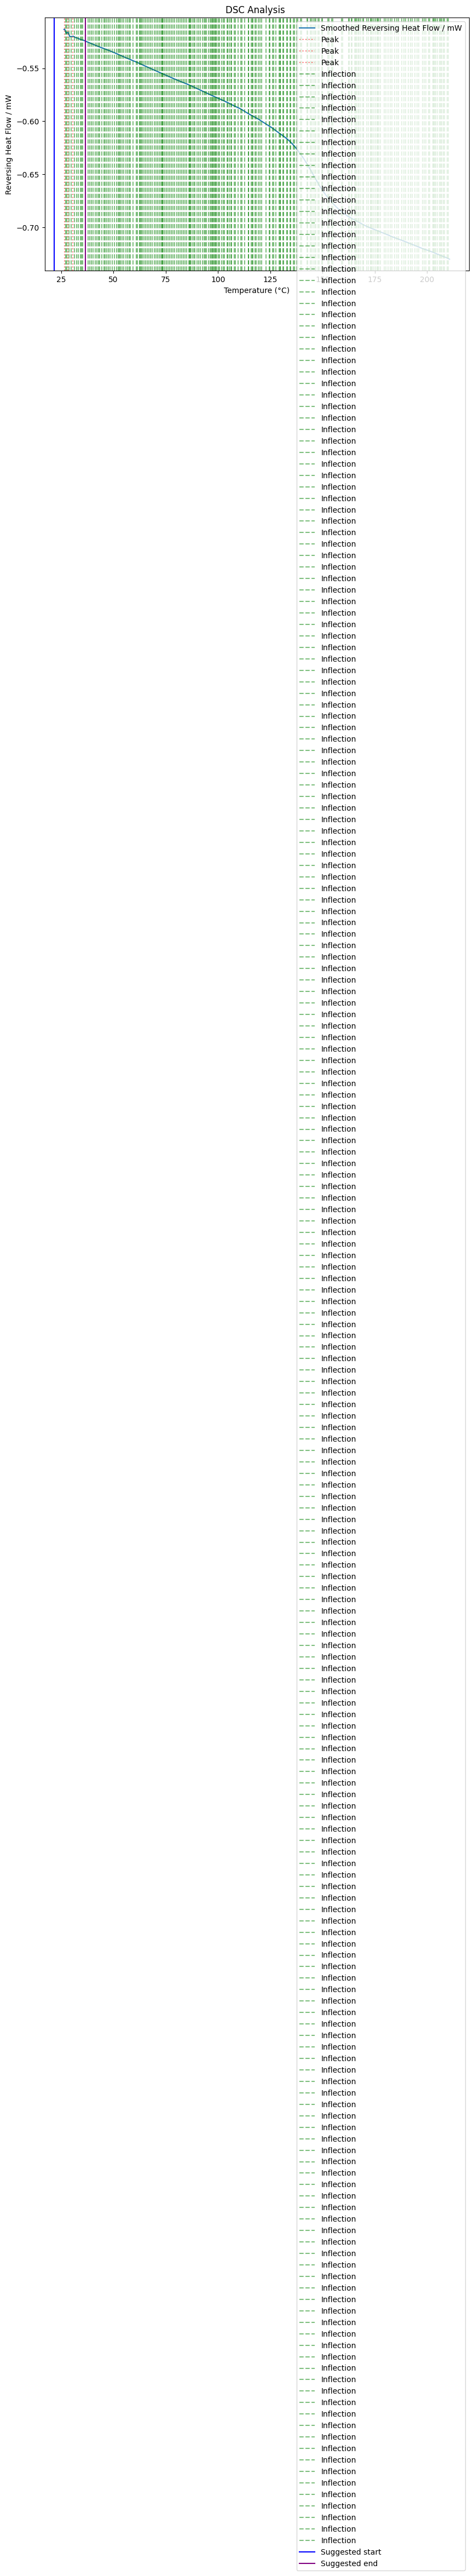

In [ ]:
# --- 10. Plot ---
plt.figure(figsize=(10,6))
temp_subset = features["temperature"]
smoothed_subset = features["smoothed"]
plt.plot(temp_subset, smoothed_subset, label=f"Smoothed {features['hf_col']}")
# No need to slice peaks, inflections, or limits as they represent specific points
for x in features["peaks"]:
    plt.axvline(x, color="red", linestyle=":", alpha=0.5, label="Peak")
# Plot only inflections within the temperature range of the subset
for x in features["inflections"]:
    if temp_subset.min() <= x <= temp_subset.max():
        plt.axvline(x, color="green", linestyle="--", alpha=0.5, label="Inflection")
if "start" in limits:
    plt.axvline(limits["start"], color="blue", linestyle="-", label="Suggested start")
if "end" in limits:
    plt.axvline(limits["end"], color="purple", linestyle="-", label="Suggested end")
plt.xlabel("Temperature (°C)")
plt.ylabel(features["hf_col"])
plt.title("DSC Analysis ") # Updated title
plt.legend()
plt.show()

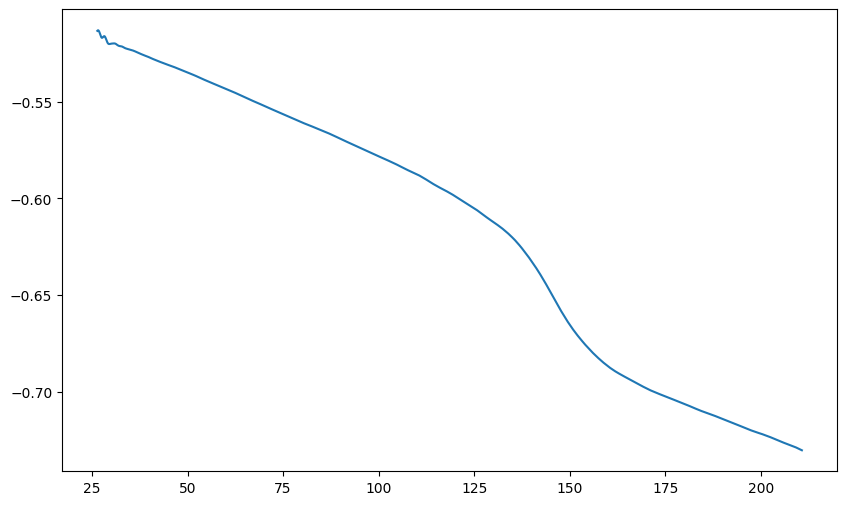

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(df_selected['Temperature / °C'], df_selected['Reversing Heat Flow / mW'], label='Reversing Heat Flow')

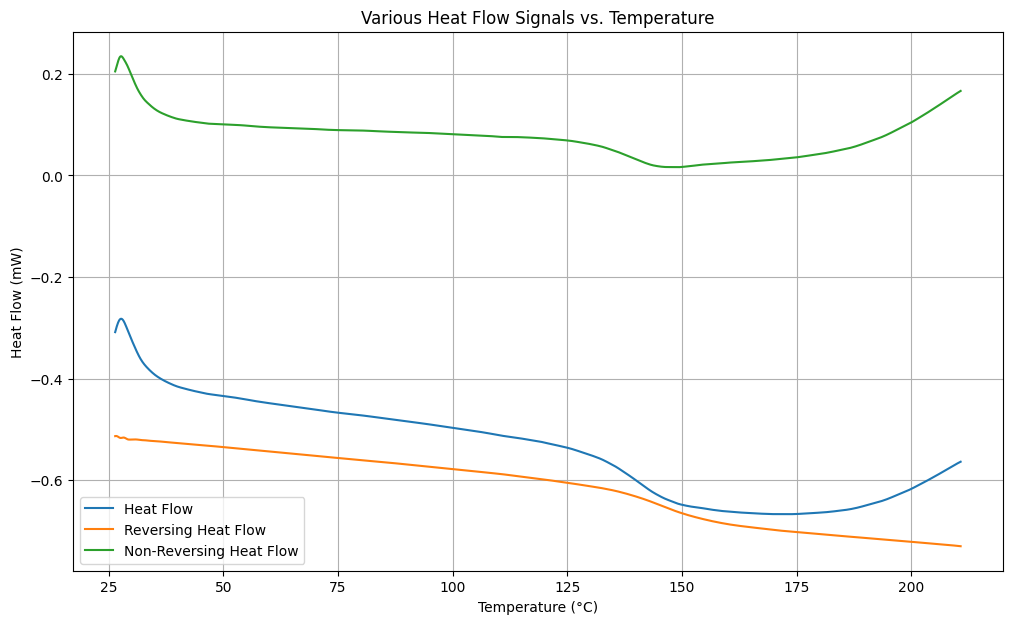

In [ ]:
#Generate a plot showing 'Heat Flow / mW', 'Reversing Heat Flow / mW', and 'Non-Reversing Heat Flow / mW' against 'Temperature / °C'.
plt.figure(figsize=(12, 7))
plt.plot(df['Temperature / °C'], df['Heat Flow / mW'], label='Heat Flow')
plt.plot(df['Temperature / °C'], df['Reversing Heat Flow / mW'], label='Reversing Heat Flow')
plt.plot(df['Temperature / °C'], df['Non-Reversing Heat Flow / mW'], label='Non-Reversing Heat Flow')
plt.xlabel('Temperature (°C)')
plt.ylabel('Heat Flow (mW)')
plt.title('Various Heat Flow Signals vs. Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Thermal resistance is a measure of a material's ability to resist the flow of heat, indicating how well it can insulate against heat transfer.
# Define the formula for calculating Thermal Resistance
# Rth = (Tj - Ta) / Pd

def calculate_thermal_resistance(junction_temp, ambient_temp, power_dissipation):
  """
  Calculates the thermal resistance.

  Args:
    junction_temp: Junction Temperature in degrees Celsius.
    ambient_temp: Ambient Temperature in degrees Celsius.
    power_dissipation: Power Dissipation in Watts.

  Returns:
    The thermal resistance in degrees Celsius per Watt.
  """
  # Avoid division by zero
  if power_dissipation == 0:
      return float('nan')
  thermal_resistance = (junction_temp - ambient_temp) / power_dissipation
  return thermal_resistance

# Use the available data from the DataFrame
# Assuming:
# Tj (Junction Temperature) is 'Reference Junction Temperature / °C'
# Ta (Ambient Temperature) is 'Heater Temp / °C'
# Pd (Power Dissipation) is 'Power Delivered / W'

# Calculate Thermal Resistance for the experiment
df_subset = df.head()

print("Calculated Thermal Resistance")
for index, row in df_subset.iterrows():
    junction_temp = row['Reference Junction Temperature / °C']
    ambient_temp = row['Heater Temp / °C']
    power_dissipation = row['Power Delivered / W']

    rth = calculate_thermal_resistance(junction_temp, ambient_temp, power_dissipation)
    print(f"Row {index}: Rth = {rth:.4f} °C/W (Tj={junction_temp:.2f}, Ta={ambient_temp:.2f}, Pd={power_dissipation:.2f})")

Calculated Thermal Resistance
Row 80: Rth = 0.7147 °C/W (Tj=46.17, Ta=28.30, Pd=25.00)
Row 81: Rth = 0.7582 °C/W (Tj=46.17, Ta=28.45, Pd=23.37)
Row 82: Rth = 0.8307 °C/W (Tj=46.17, Ta=28.58, Pd=21.17)
Row 83: Rth = 0.9510 °C/W (Tj=46.17, Ta=28.70, Pd=18.37)
Row 84: Rth = 1.1407 °C/W (Tj=46.17, Ta=28.80, Pd=15.23)


### Interpreting Critical Temperatures

The detected peaks and inflection points in the DSC curve often correspond to important thermal transitions in the material:

*   **Peaks (Endothermic or Exothermic):** These can represent processes like melting (endothermic, heat absorbed) or crystallization (exothermic, heat released). Knowing the melting point is crucial for defining the maximum operating temperature for a component made from this material.
*   **Inflection Points:** Changes in the slope of the heat flow curve (often seen as inflection points) can indicate glass transitions, where an amorphous material changes from a rigid, glassy state to a more flexible, rubbery state. The glass transition temperature ($T_g$) is important as it affects mechanical properties and dimensional stability.

Let's display the detected peaks and inflections again as these are the critical temperatures.

In [ ]:
print("Detected peaks (potential melting/crystallization points):", features["peaks"])
print("Detected inflections (potential glass transition points or other changes):", features["inflections"])

Detected peaks (potential melting/crystallization points): [26.601037979126, 28.1802978515625, 30.7168979644775]
Detected inflections (potential glass transition points or other changes): [27.0863361358643, 27.8370990753174, 28.7383670806885, 29.7466621398926, 31.48410987854, 32.345100402832, 33.2185287475586, 34.1818885803223, 34.7481842041016, 35.3171234130859, 36.5428314208984, 37.9399337768555, 38.6822853088379, 39.5089645385742, 40.337100982666, 41.2490348815918, 42.2448692321777, 42.9093170166016, 43.4909934997559, 44.571590423584, 45.4031181335449, 46.0686149597168, 46.9007301330566, 47.6496925354004, 48.3155860900879, 49.4814109802246, 50.3976974487305, 51.4805335998535, 52.3133583068848, 52.8963432312012, 53.4793548583984, 54.2288818359375, 54.8951721191406, 55.9781150817871, 56.7278823852539, 57.5608291625977, 58.1438751220703, 59.476734161377, 60.976619720459, 61.4766883850098, 62.560245513916, 62.8103103637695, 63.3104591369629, 63.8939590454102, 64.6442337036133, 65.394577

### Using Critical Temperatures for Device Improvement

**1. Understanding Material Limitations:**

The temperatures of the detected peaks, especially melting points, are critical limits. Operating a device component made of this material above its melting point would likely cause irreversible damage. The glass transition temperature (if an inflection point corresponds to one) is also a limit for applications where mechanical rigidity or dimensional stability is required.

**2. Guiding Manufacturing Processes:**

For processes like curing, annealing, or reflow soldering that involve heating the material, knowing the transition temperatures helps in designing appropriate temperature profiles. You want to ensure the material reaches the necessary temperatures for the process to complete without exceeding temperatures that would cause degradation or unintended phase changes.

We can illustrate this by highlighting the first peak and the last inflection before it (which we used for limit suggestion), as these are often relevant for identifying a processing window or the onset of a major transition.

In [ ]:
first_peak = features["peaks"][0] if features["peaks"] else "No peaks found"

# Modify the next() call to only compare if first_peak is a number
if isinstance(first_peak, (int, float)):
    last_inflection_before_peak = next((x for x in reversed(features["inflections"]) if x < first_peak), "No inflection before first peak")
else:
    # If no peak was found, there is no inflection before the first peak
    last_inflection_before_peak = "No inflection before first peak (no peaks found)"


print(f"First detected peak: {first_peak} °C")
print(f"Last inflection before first peak: {last_inflection_before_peak} °C")

# This temperature range between the last inflection and the first peak
# might be relevant for understanding a processing window or the start of a transition.

First detected peak: 26.601037979126 °C
Last inflection before first peak: No inflection before first peak °C


**3. Assessing Material Stability and Behavior (Visual Inspection):**

The shape of the smoothed heat flow curve itself provides insights into material stability. Broad transitions or unexpected features could indicate impurities or complex thermal behavior. While not directly quantifiable from the peak/inflection list, visually inspecting the plot (which we generated earlier) is crucial here. A stable material might show relatively flat regions between transitions.

### Analyzing Derivatives for Subtle Changes

The first and second derivatives of the smoothed heat flow data can help highlight subtle changes in the material's thermal behavior that might not be immediately obvious in the primary heat flow curve.

*   **First Derivative:** Represents the rate of change of the heat flow with respect to temperature. Changes in the slope of the heat flow curve appear as peaks or valleys in the first derivative. Subtle changes in slope can indicate less pronounced transitions.
*   **Second Derivative:** Represents the rate of change of the first derivative (or the curvature of the heat flow curve). Inflection points in the heat flow curve correspond to zero-crossings in the second derivative. Subtle changes in curvature can also be detected.

Let's plot the smoothed heat flow along with its first and second derivatives.

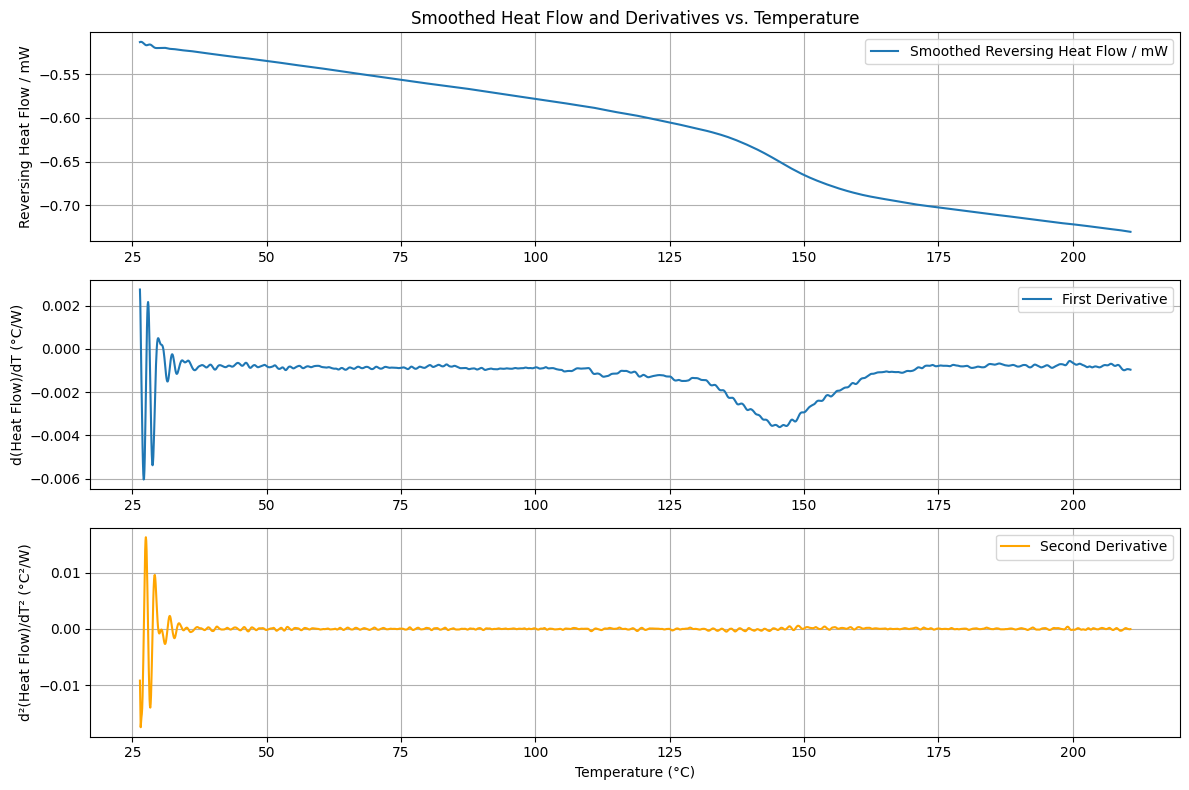

In [ ]:
# Use the features dictionary which already contains calculated derivatives
temperature = features["temperature"]
smoothed_hf = features["smoothed"]
first_derivative = features["first_derivative"]
second_derivative = features["second_derivative"]
hf_col = features["hf_col"]

plt.figure(figsize=(12, 8))

# Plot Smoothed Heat Flow
plt.subplot(3, 1, 1)
plt.plot(temperature, smoothed_hf, label=f"Smoothed {hf_col}")
plt.ylabel(hf_col)
plt.title("Smoothed Heat Flow and Derivatives vs. Temperature")
plt.legend()
plt.grid(True)

# Plot First Derivative
plt.subplot(3, 1, 2)
plt.plot(temperature, first_derivative, label="First Derivative")
plt.ylabel("d(Heat Flow)/dT (°C/W)")
plt.legend()
plt.grid(True)

# Plot Second Derivative
plt.subplot(3, 1, 3)
plt.plot(temperature, second_derivative, label="Second Derivative", color='orange')
plt.xlabel("Temperature (°C)")
plt.ylabel("d²(Heat Flow)/dT² (°C²/W)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Interpreting the Derivative Plots

When examining these plots for subtle instability or changes:

*   Look for small peaks or valleys in the **first derivative** that don't correspond to the major transitions seen in the heat flow curve. These can indicate subtle changes in the rate of heat absorption or release.
*   Look for small deviations or wiggles around the zero line in the **second derivative**, especially in regions that appear flat in the heat flow plot. Zero-crossings in the second derivative pinpoint inflection points; subtle wiggles can suggest minor changes in the curvature of the heat flow curve.

These subtle features in the derivative plots can sometimes reveal minor transitions, relaxation phenomena, or other subtle changes in the material's behavior that are indicative of slight instability or variations in the material's structure or composition.

In [ ]:
# it is a key factor in how quickly a material's temperature changes when heat is applied
# Check if 'Reversing Heat Capacity / J/°C' column exists
if 'Reversing Heat Capacity / J/°C' in df.columns:
    # Calculate the average Reversing Heat Capacity
    average_heat_capacity = df['Reversing Heat Capacity / J/°C'].mean()

    print(f"Average Reversing Heat Capacity of the sample: {average_heat_capacity:.4f} J/°C")
else:
    print("The 'Reversing Heat Capacity / J/°C' column is not available in the dataset.")

Average Reversing Heat Capacity of the sample: 0.0074 J/°C


Here's how you could potentially use this metric:

1. **Establish a Baseline:**  
   Run a standard "oven check" or a well-characterized reference sample when you know the machine is operating correctly. Calculate the "Machine Thermal Resistance" during this run and consider it your baseline.

2. **Monitor for Deviations:**  
   For subsequent experiments, calculate the "Machine Thermal Resistance" and compare it to your established baseline.

3. **Identify Potential Issues:**  
   Significant deviations from the baseline (e.g., a consistent increase or decrease, or sudden fluctuations) could potentially indicate a change in the instrument's thermal behavior. This might suggest issues with components like the heater, temperature sensors, or thermal insulation.


Calculated 'Machine Thermal Resistance' for the first 5 rows:


,Temperature / °C,Heater Temp / °C,Reference Junction Temperature / °C,Power Delivered / W,Machine Thermal Resistance (°C/W)
80,26.389071,28.298853,46.168488,25.002821,-0.714705
81,26.460039,28.450811,46.168518,23.367958,-0.758205
82,26.530691,28.583122,46.168560,21.169321,-0.830704
83,26.601038,28.697359,46.168598,18.372305,-0.950955
84,26.671097,28.798838,46.168625,15.227272,-1.140702
...,...,...,...,...,...
2301,210.431412,207.510223,46.166355,90.352661,1.785712
2302,210.514771,207.528687,46.166351,92.911629,1.736729
2303,210.598129,207.573715,46.166348,95.086624,1.697477
2304,210.681473,207.643661,46.166351,97.081299,1.663320


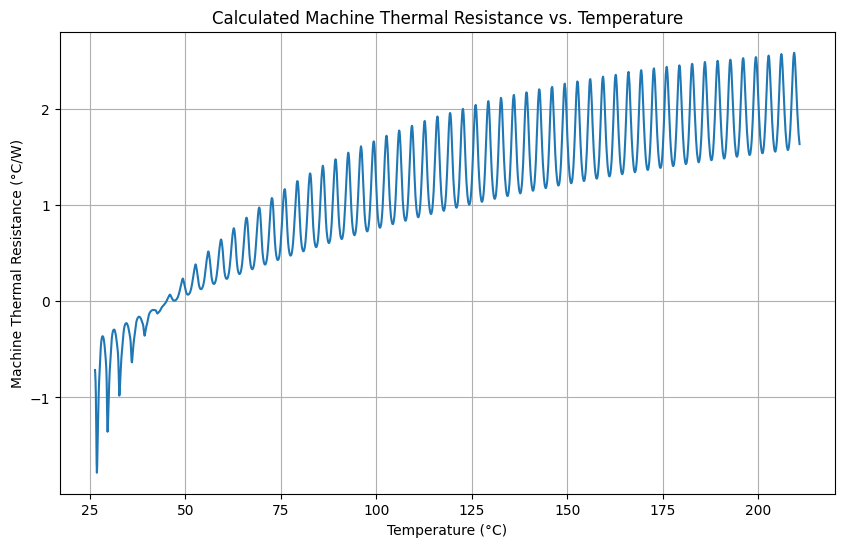

In [ ]:
# Calculate a "Machine Thermal Resistance"
# Using the temperature difference between Heater Temp and Reference Junction Temperature
# And the Power Delivered


def calculate_machine_thermal_resistance(heater_temp, reference_junction_temp, power_delivered):
  """
  Calculates a value analogous to thermal resistance for the machine.

  Args:
    heater_temp: Heater Temperature in degrees Celsius.
    reference_junction_temp: Reference Junction Temperature in degrees Celsius.
    power_delivered: Power Delivered in Watts.

  Returns:
    A calculated "machine thermal resistance" in degrees Celsius per Watt, or NaN if power is zero.
  """
  temp_difference = heater_temp - reference_junction_temp
  # Avoid division by zero
  if power_delivered == 0:
      return float('nan')
  machine_rth = temp_difference / power_delivered
  return machine_rth

# Apply the calculation to each row of the DataFrame
if 'Heater Temp / °C' in df.columns and 'Reference Junction Temperature / °C' in df.columns and 'Power Delivered / W' in df.columns:
    df['Machine Thermal Resistance (°C/W)'] = df.apply(
        lambda row: calculate_machine_thermal_resistance(
            row['Heater Temp / °C'],
            row['Reference Junction Temperature / °C'],
            row['Power Delivered / W']
        ),
        axis=1
    )

    print("Calculated 'Machine Thermal Resistance' for the first 5 rows:")
    display(df[['Temperature / °C', 'Heater Temp / °C', 'Reference Junction Temperature / °C', 'Power Delivered / W', 'Machine Thermal Resistance (°C/W)']])

    # Optionally, plot the calculated machine thermal resistance
    plt.figure(figsize=(10, 6))
    plt.plot(df['Temperature / °C'], df['Machine Thermal Resistance (°C/W)'])
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Machine Thermal Resistance (°C/W)")
    plt.title("Calculated Machine Thermal Resistance vs. Temperature")
    plt.grid(True)
    plt.show()

else:
    print("Required columns ('Heater Temp / °C', 'Reference Junction Temperature / °C', or 'Power Delivered / W') not found in the DataFrame.")

Calculated Thermal Resistance
Row 80: Rth = 1.5043 °C/W (Tj=46.18, Ta=28.59, Pd=11.69)
Row 81: Rth = 1.8283 °C/W (Tj=46.18, Ta=28.65, Pd=9.59)
Row 82: Rth = 1.9430 °C/W (Tj=46.18, Ta=28.66, Pd=9.01)
Row 83: Rth = 1.8412 °C/W (Tj=46.18, Ta=28.62, Pd=9.53)
Row 84: Rth = 1.7271 °C/W (Tj=46.18, Ta=28.55, Pd=10.21)
Calculated 'Machine Thermal Resistance baseline' 


,Temperature / °C,Heater Temp / °C,Reference Junction Temperature / °C,Power Delivered / W,Machine Thermal Resistance (°C/W)
80,26.385303,28.587936,46.175392,11.691219,-1.504330
81,26.454878,28.649853,46.175385,9.585728,-1.828294
82,26.524204,28.661495,46.175388,9.013871,-1.942993
83,26.593302,28.622223,46.175392,9.533676,-1.841175
84,26.662195,28.550694,46.175388,10.205004,-1.727064
...,...,...,...,...,...
2299,210.292130,207.221359,46.177761,97.522934,1.651341
2300,210.375488,207.313995,46.177750,99.226219,1.623928
2301,210.458862,207.433731,46.177757,100.843498,1.599072
2302,210.542221,207.579666,46.177761,101.996201,1.582431


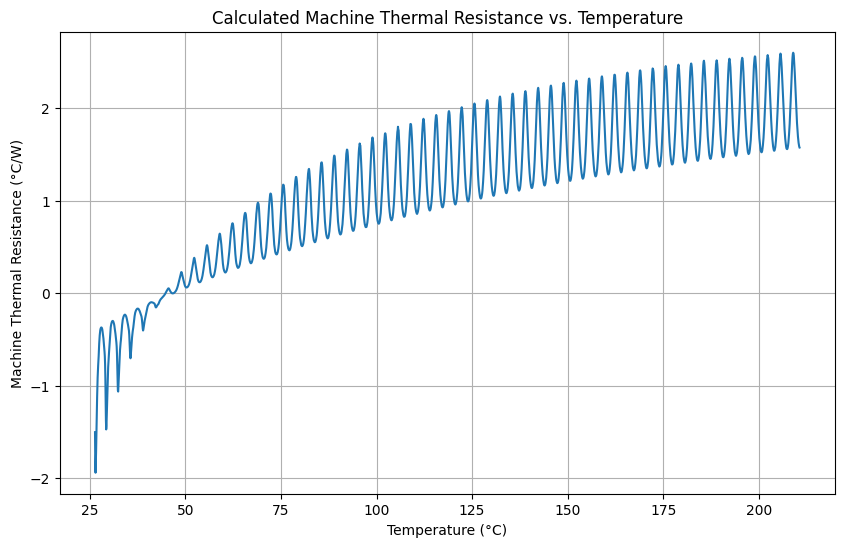

In [ ]:
 #Calculate baseline Thermal Resistance for the experiment
df_subset = baseline_df.head()

print("Calculated baseline Thermal Resistance")
for index, row in df_subset.iterrows():
    junction_temp = row['Reference Junction Temperature / °C']
    ambient_temp = row['Heater Temp / °C']
    power_dissipation = row['Power Delivered / W']

    rth = calculate_thermal_resistance(junction_temp, ambient_temp, power_dissipation)
    print(f"Row {index}: Rth = {rth:.4f} °C/W (Tj={junction_temp:.2f}, Ta={ambient_temp:.2f}, Pd={power_dissipation:.2f})")

# calculate machine thermal resistance baseline and Apply the calculation to each row of the DataFrame
if 'Heater Temp / °C' in baseline_df.columns and 'Reference Junction Temperature / °C' in baseline_df.columns and 'Power Delivered / W' in baseline_df.columns:
    baseline_df['Machine Thermal Resistance (°C/W)'] = baseline_df.apply(
        lambda row: calculate_machine_thermal_resistance(
            row['Heater Temp / °C'],
            row['Reference Junction Temperature / °C'],
            row['Power Delivered / W']
        ),
        axis=1
    )

    print("Calculated 'Machine Thermal Resistance baseline' ")
    display(baseline_df[['Temperature / °C', 'Heater Temp / °C', 'Reference Junction Temperature / °C', 'Power Delivered / W', 'Machine Thermal Resistance (°C/W)']])

    # Optionally, plot the calculated machine thermal resistance
    plt.figure(figsize=(10, 6))
    plt.plot(baseline_df['Temperature / °C'], baseline_df['Machine Thermal Resistance (°C/W)'])
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Machine Thermal Resistance (°C/W)")
    plt.title("Calculated Machine Thermal Resistance vs. Temperature")
    plt.grid(True)
    plt.show()

else:
    print("Required columns ('Heater Temp / °C', 'Reference Junction Temperature / °C', or 'Power Delivered / W') not found in the DataFrame.")

In [ ]:
# write code to compare baseline_df with df , look for any deviations in machine thermal resistance . baseline_df is the baseline



Comparison of Machine Thermal Resistance :


,Temperature / °C,Machine Thermal Resistance (°C/W)_experiment,Machine Thermal Resistance (°C/W)_baseline,Thermal Resistance Difference (°C/W)
0,26.385303,NaN,-1.504330,NaN
1,26.389071,-0.714705,NaN,NaN
2,26.454878,NaN,-1.828294,NaN
3,26.460039,-0.758205,NaN,NaN
4,26.524204,NaN,-1.942993,NaN
...,...,...,...,...
4445,210.542221,NaN,1.582431,NaN
4446,210.598129,1.697477,NaN,NaN
4447,210.625595,NaN,1.573561,NaN
4448,210.681473,1.663320,NaN,NaN


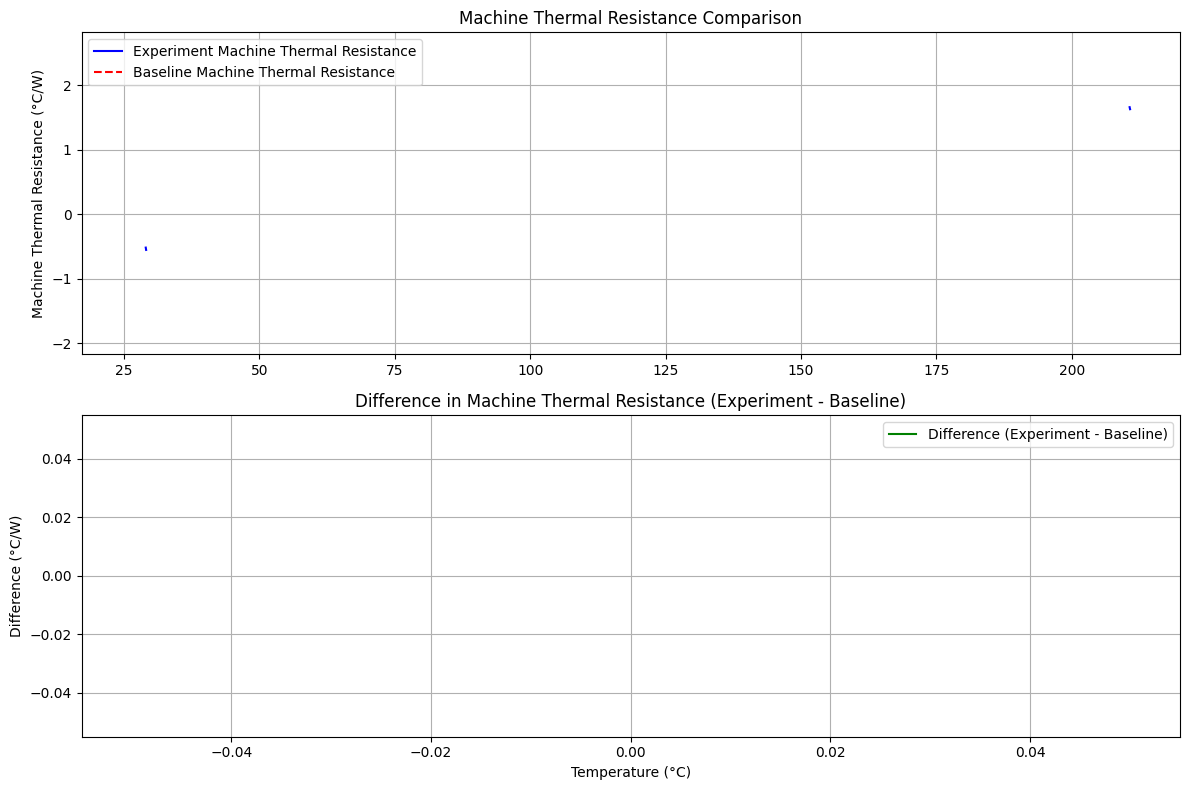

In [209]:
# Merge the two dataframes on 'Temperature / °C' to compare thermal resistance at similar temperatures
# Using 'outer' merge to keep all data points and fill missing with NaN
comparison_df = pd.merge(
    df[['Temperature / °C', 'Machine Thermal Resistance (°C/W)']],
    baseline_df[['Temperature / °C', 'Machine Thermal Resistance (°C/W)']],
    on='Temperature / °C',
    suffixes=('_experiment', '_baseline'),
    how='outer' # Use outer merge to see where temperatures might not align perfectly
)

# Sort by temperature for plotting
comparison_df.sort_values(by='Temperature / °C', inplace=True)

# Calculate the difference in thermal resistance
comparison_df['Thermal Resistance Difference (°C/W)'] = comparison_df['Machine Thermal Resistance (°C/W)_experiment'] - comparison_df['Machine Thermal Resistance (°C/W)_baseline']

print("Comparison of Machine Thermal Resistance :")
display(comparison_df)

# Plot the thermal resistance from both dataframes and the difference
plt.figure(figsize=(12, 8))

# Plot Experiment Thermal Resistance
plt.subplot(2, 1, 1)
plt.plot(comparison_df['Temperature / °C'], comparison_df['Machine Thermal Resistance (°C/W)_experiment'], label='Experiment Machine Thermal Resistance', color='blue')
plt.plot(comparison_df['Temperature / °C'], comparison_df['Machine Thermal Resistance (°C/W)_baseline'], label='Baseline Machine Thermal Resistance', color='red', linestyle='--')
plt.ylabel("Machine Thermal Resistance (°C/W)")
plt.title("Machine Thermal Resistance Comparison")
plt.legend()
plt.grid(True)

# Plot the difference
plt.subplot(2, 1, 2)
plt.plot(comparison_df['Temperature / °C'], comparison_df['Thermal Resistance Difference (°C/W)'], label='Difference (Experiment - Baseline)', color='green')
plt.xlabel("Temperature (°C)")
plt.ylabel("Difference (°C/W)")
plt.title("Difference in Machine Thermal Resistance (Experiment - Baseline)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [212]:
# List any deviations between the baseline and experiment thermal resistance
# Define a threshold for significant deviation
deviation_threshold = 0 # You can adjust this value based on what you consider a significant deviation

# Filter the comparison_df to show rows where the absolute difference is greater than the threshold
deviations_df = comparison_df[abs(comparison_df['Thermal Resistance Difference (°C/W)']) > deviation_threshold]

print("\nDeviations in Machine Thermal Resistance (where difference >):")
display(deviations_df)

if deviations_df.empty:
    print("No significant deviations found based on the threshold.")


Deviations in Machine Thermal Resistance (where difference >):


,Temperature / °C,Machine Thermal Resistance (°C/W)_experiment,Machine Thermal Resistance (°C/W)_baseline,Thermal Resistance Difference (°C/W)


No significant deviations found based on the threshold.
